## To analyse the brain segmentation results

In [1]:
RUN_ID = 94
MASK_CODE = RUN_ID - 80
# USE_PROCESSED = True
# ONLY_MEDIAN = False
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/brats_seg"
DATA_ROOT_DIR = "/scratch1/sachinsa/data"

In [2]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.logger import Logger
from utils.plot import *
from itertools import chain, combinations

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir = os.path.join("..", "figs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [4]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']
    metric_values_tc = training_info['metric_values_tc']
    metric_values_wt = training_info['metric_values_wt']
    metric_values_et = training_info['metric_values_et']

In [5]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)
logger.info(f"Total epochs: {max_epochs}")

[INFO] Total epochs: 200


In [6]:
def all_subsets(arr):
    subsets = list(chain.from_iterable(combinations(arr, r) for r in range(0, len(arr))))
    return [list(subset) for subset in subsets]

mask_indices = all_subsets([0, 1, 2, 3])[MASK_CODE]
show_indices = [x for x in [0, 1, 2, 3] if x not in mask_indices]
channels = ["FLAIR", "T1w", "T1Gd", "T2w"]
label_list = ["TC", "WT", "ET"]

### Plot the loss and metric

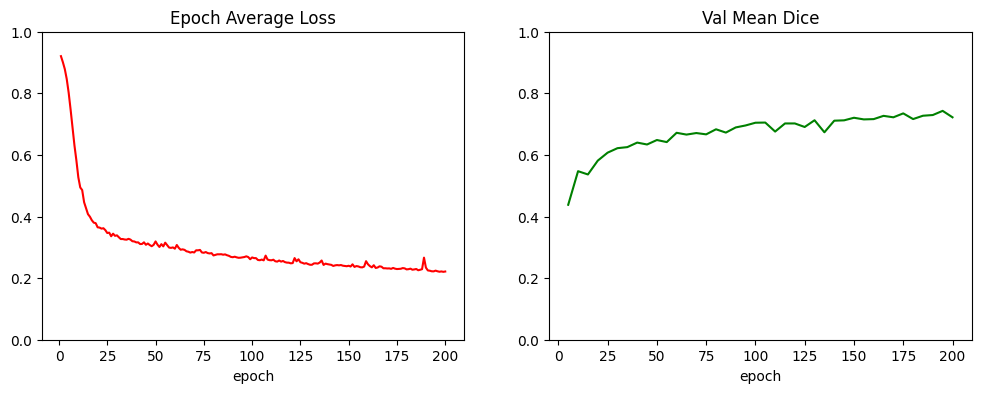

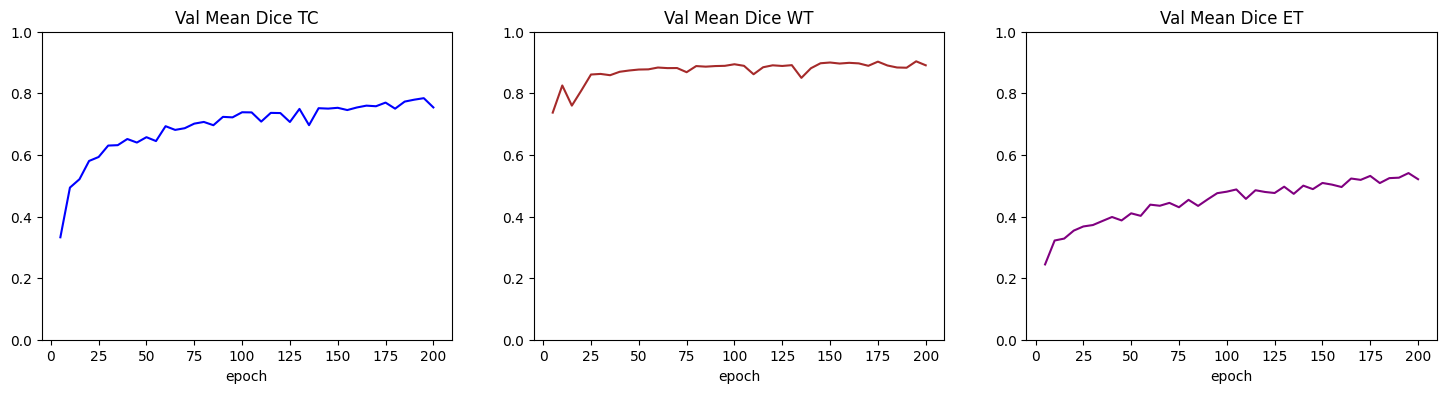

In [7]:
plt.figure("train", (12, 4))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 4))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.ylim((0, 1))
plt.plot(x, y, color="purple")
plt.show()

Masked contrasts: ['T1w', 'T1Gd', 'T2w']
Epochs  Total	TC	WT	ET
200	74.3	78.4	90.4	54.1


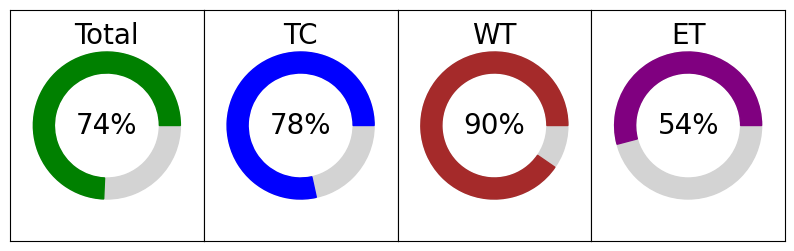

In [8]:
metric = np.max(metric_values)
arg_max = np.argmax(metric_values)
metric_tc = metric_values_tc[arg_max]
metric_wt = metric_values_wt[arg_max]
metric_et = metric_values_et[arg_max]

print(f"Masked contrasts: {[channels[i] for i in mask_indices]}")
print(f"Epochs  Total	TC	WT	ET")
print(f"{len(epoch_loss_values)}	{100*metric:.1f}	{100*metric_tc:.1f}	{100*metric_wt:.1f}	{100*metric_et:.1f}")


fig, axs = plt.subplots(1,4, figsize=(10, 3),gridspec_kw={'wspace': 0, 'hspace': 0})
plot_donut(metric, "Total", "green", axs[0])
plot_donut(metric_tc, "TC", "blue", axs[1])
plot_donut(metric_wt, "WT", "brown", axs[2])
plot_donut(metric_et, "ET", "purple", axs[3])
plt.show()



## Inference on the model

In [9]:
import torch
from monai.transforms import (
    Compose,
)
from monai.config import print_config
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
)
from monai.utils import set_determinism

from tqdm import tqdm
from utils.transforms import tumor_seg_transform as data_transform
from utils.model import create_SegResNet, inference
from utils.dataset import BraTSDataset

In [10]:
device = torch.device("cuda:0")
in_channels = len(show_indices)
model = create_SegResNet(in_channels, device)

In [11]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [12]:
val_dataset = BraTSDataset(
    version='2017',
    # processed = USE_PROCESSED,
    section = 'validation',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)

In [13]:
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [14]:
this_index = 0

In [15]:
id_ = 60 # np.sort(val_dataset.get_ids())[this_index]
this_index += 1
print(id_)

with torch.no_grad():
    this_input = val_dataset.get_with_id(id_)
    input_image = this_input["image"].unsqueeze(0).to(device)
    input_image = input_image[:, show_indices, ...]
    input_label = this_input["label"]
    this_output = inference(input_image, model)
    this_output = post_trans(this_output[0])

60


In [16]:
def find_ratio_of_ones(tensor):
    total_elements = tensor.numel()
    count_ones = torch.sum(tensor)
    ratio = count_ones.float() / total_elements
    return ratio.item()

def tensor_to_sorted_tuple(tensor):
    unique_values, counts = torch.unique(tensor, return_counts=True)
    result = list(zip(unique_values.tolist(), counts.tolist()))
    result.sort(key=lambda x: x[1], reverse=True)
    return tuple(result)
    
def find_centroid_3d(tensor):
    print(f"TC: {find_ratio_of_ones(tensor)*100:.5f}%")
    indices = torch.nonzero(tensor, as_tuple=False)

    print(len(indices))
    # pdb.set_trace()
    print(tensor_to_sorted_tuple(indices[:, 2]))

    if indices.shape[0] == 0:
        shape = torch.tensor(tensor.shape, dtype=torch.float32)
        midpoint = (shape - 1) / 2
        return midpoint.round().to(torch.int64)

    centroid = torch.mean(indices.float(), dim=0).round().to(torch.int64)
    return centroid
    
label_centroid =  find_centroid_3d(input_label[0]) # centroid of TC (Tumor Core)
print(label_centroid)

TC: 0.98774%
88185
((79, 2025), (78, 1977), (80, 1972), (77, 1929), (81, 1928), (67, 1914), (82, 1908), (68, 1895), (75, 1885), (69, 1881), (76, 1872), (70, 1870), (64, 1851), (66, 1845), (83, 1845), (71, 1837), (72, 1833), (84, 1825), (65, 1821), (86, 1811), (73, 1795), (74, 1786), (85, 1777), (63, 1720), (87, 1709), (88, 1655), (89, 1636), (62, 1629), (90, 1591), (60, 1561), (61, 1542), (92, 1475), (91, 1461), (59, 1436), (93, 1301), (58, 1285), (56, 1121), (57, 1110), (55, 1024), (94, 1019), (54, 1002), (53, 943), (52, 853), (45, 852), (46, 844), (51, 834), (48, 825), (42, 811), (50, 798), (47, 778), (44, 775), (49, 772), (43, 749), (95, 747), (41, 673), (40, 627), (36, 602), (96, 587), (39, 582), (37, 523), (38, 503), (35, 458), (33, 426), (34, 415), (32, 375), (31, 365), (97, 358), (30, 303), (98, 299), (99, 267), (100, 250), (29, 228), (101, 215), (102, 207), (103, 190), (104, 161), (28, 138), (105, 124), (27, 75), (106, 62), (26, 47), (25, 40), (108, 32), (107, 29), (110, 22), (

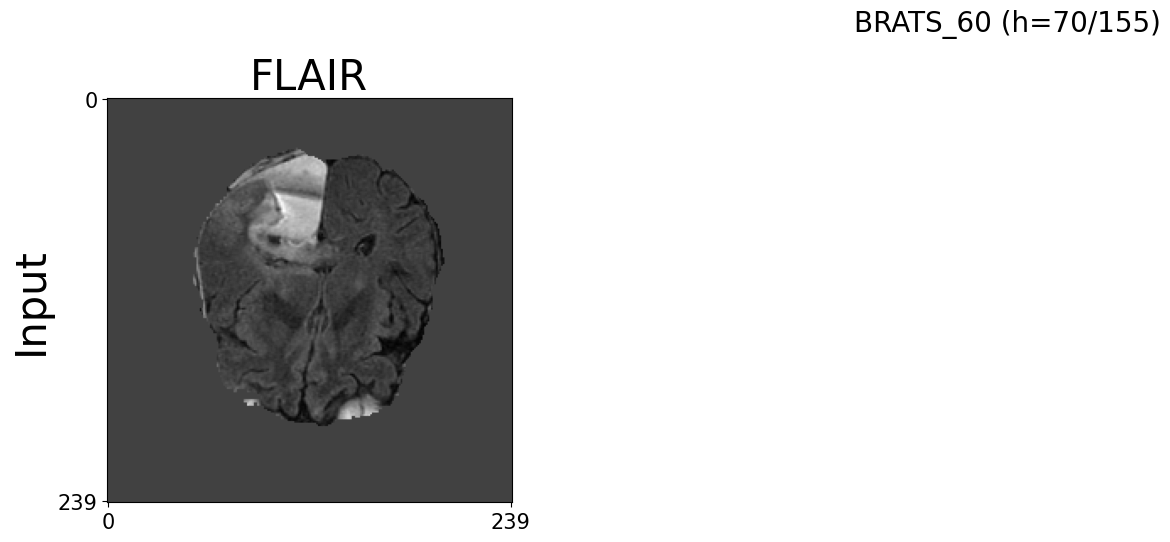

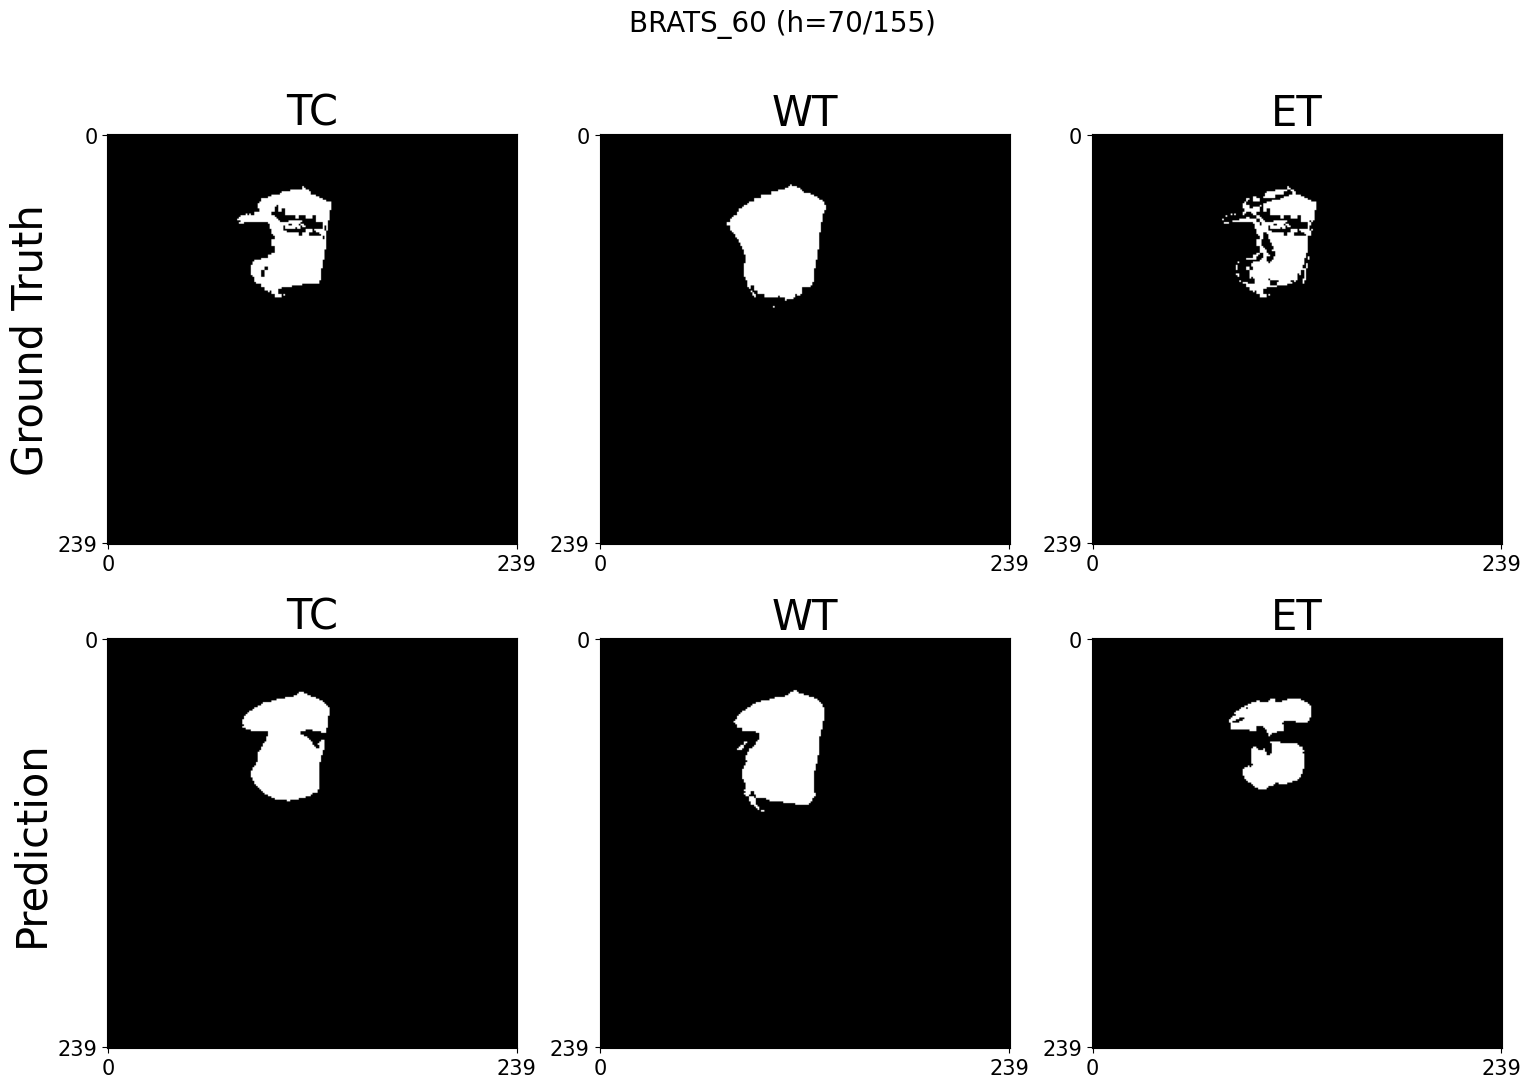

In [17]:
_, _, im_length, im_width, im_height = input_image.shape
h_index = label_centroid[-1]
label_list = ["TC", "WT", "ET"]
channels = ["FLAIR", "T1w", "T1gd", "T2w"]

def plot_brain(index, label):
    if label == "ground_truth":
        start_index = 0
        brain_slice = input_label
        title = "Ground Truth"
    elif label == "prediction":
        start_index = len(label_list)
        brain_slice = this_output
        title = "Prediction"

    brain_slice = brain_slice[index, :, :, h_index].detach().cpu().T
    plt.subplot(2, 3, start_index + index + 1)
    plt.title(label_list[index], fontsize=30)
    if index == 0:
        plt.ylabel(title, fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    plt.imshow(brain_slice, cmap="gray")


plt.figure("image", (24, 6))
for i in range(len(show_indices)):
    plt.subplot(1, 4, i + 1)
    plt.title(channels[show_indices[i]], fontsize=30)
    if i == 0:
        plt.ylabel("Input", fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    plt.imshow(input_image[0, i, :, :, h_index].detach().cpu().T, cmap="gray")
plt.suptitle(f"BRATS_{this_input['id']} (h={h_index}/{im_height})", fontsize=20)
plt.show()
    
plt.figure("label", (18, 12))
for i in range(len(label_list)):
    plot_brain(i, "ground_truth")
for i in range(len(label_list)):
    plot_brain(i, "prediction")
plt.suptitle(f"BRATS_{this_input['id']} (h={h_index}/{im_height})", fontsize=20)
plt.show()